# WorkShop 4
* Angel Molina
* Daniel Marin

#1. Exploratory Data Analysis (EDA)

Do a quick EDA that highlights some of the common texts used for each type of review

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


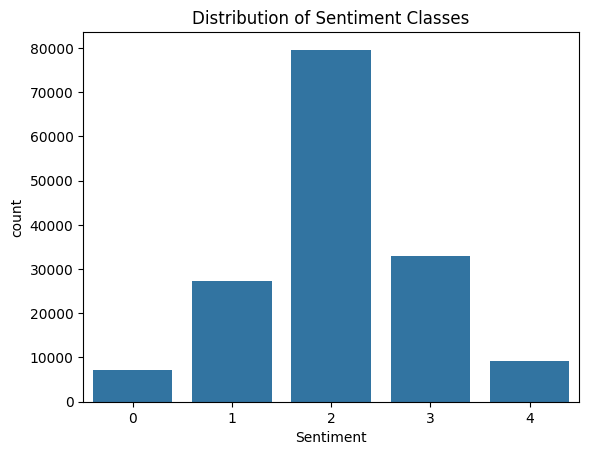

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud

# Load the data
df = pd.read_csv('data/train.tsv', sep='\t')

# Display the first few rows of the dataset
display(df)

# Display the class distribution
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.show()



Common words in sentiment 1: [('the', 9712), (',', 8847), ('a', 7327), ('of', 6552), ('and', 6078), ('to', 5437), ('.', 4432), ("'s", 3506), ('is', 3324), ('that', 2941)]


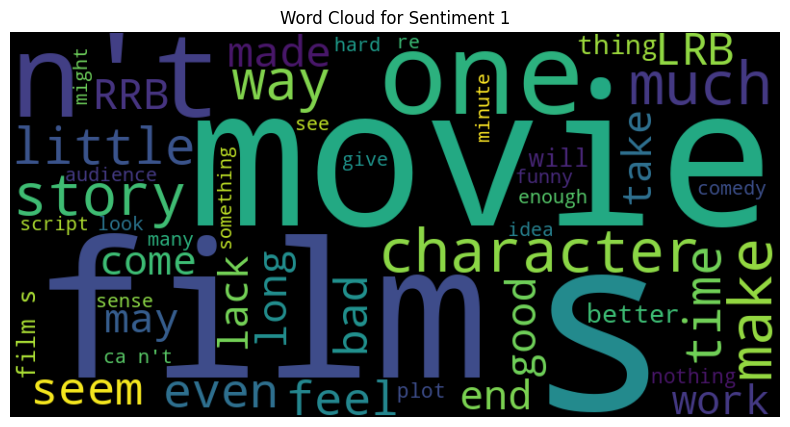

Common words in sentiment 2: [('the', 18638), (',', 13141), ('of', 12126), ('a', 11297), ('and', 10062), ('to', 8167), ("'s", 7001), ('in', 5370), ('.', 4114), ('is', 3634)]


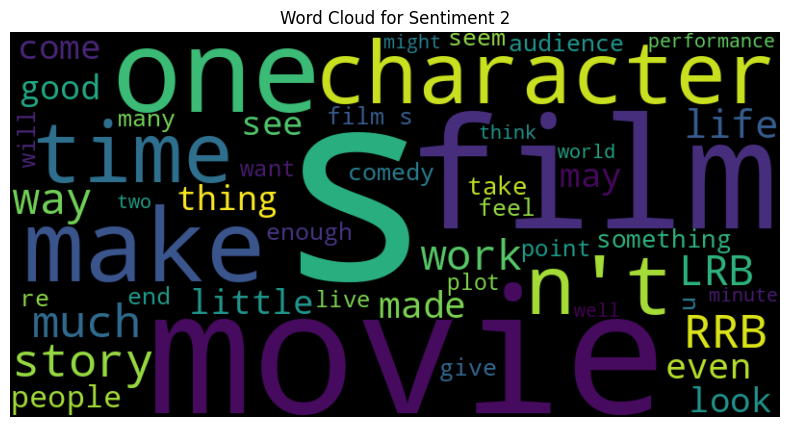

Common words in sentiment 3: [(',', 11417), ('the', 11313), ('and', 9080), ('a', 8936), ('of', 8309), ('to', 5339), ('.', 4766), ("'s", 3999), ('is', 3472), ('that', 3249)]


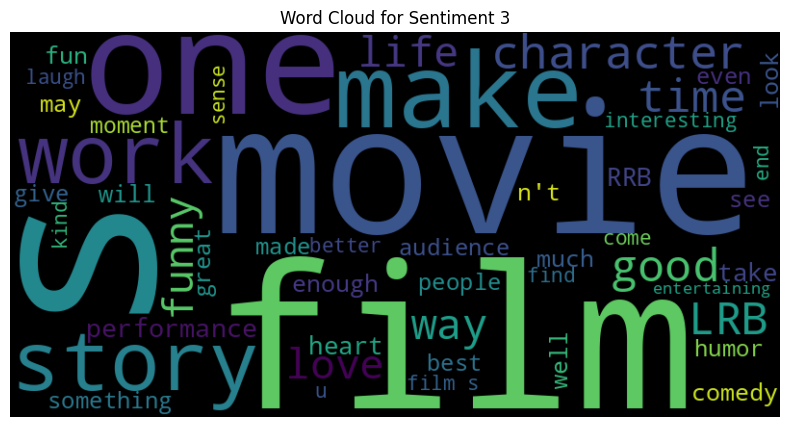

Common words in sentiment 4: [(',', 4879), ('and', 3968), ('the', 3819), ('a', 3311), ('of', 3022), ('.', 2280), ('is', 1547), ('to', 1540), ("'s", 1329), ('that', 1248)]


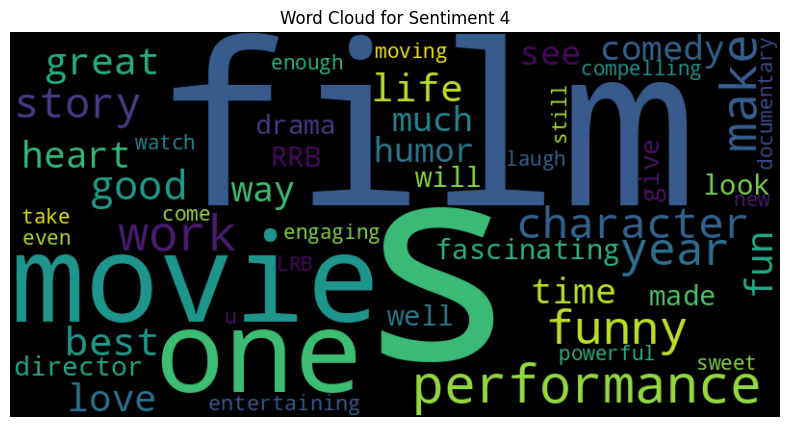

Common words in sentiment 0: [(',', 3722), ('the', 3070), ('a', 2572), ('and', 2507), ('of', 2236), ('.', 1973), ('to', 1880), ('is', 1363), ("'s", 1136), ('that', 1130)]


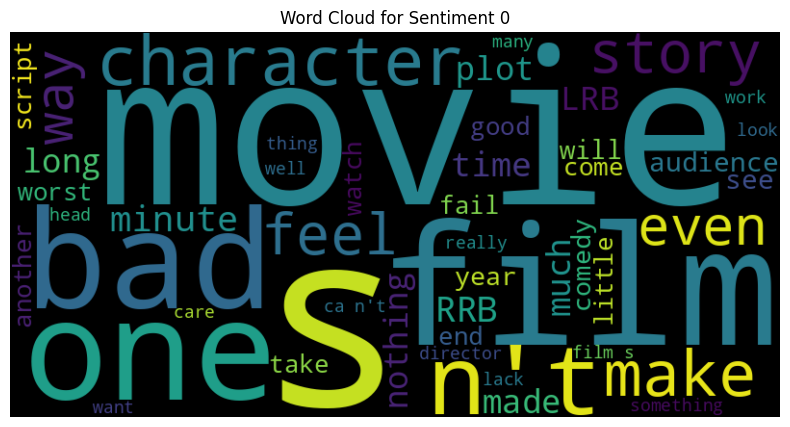

In [ ]:
# Common words in each sentiment class
for sentiment in df['Sentiment'].unique():
    subset = df[df['Sentiment'] == sentiment]
    all_words = ' '.join(subset['Phrase']).split()
    common_words = Counter(all_words).most_common(10)
    print(f"Common words in sentiment {sentiment}: {common_words}")

    # Generate word cloud for each sentiment
    wordcloud = WordCloud(width=800, height=400, max_words=50).generate(' '.join(subset['Phrase']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Sentiment {sentiment}')
    plt.show()

#2. Text Tokenization

Tokenize all the movie review texts



In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')

# Tokenize the phrases
df['Tokens'] = df['Phrase'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
display(df[['Phrase', 'Tokens']])

,Phrase,Tokens
0,A series of escapades demonstrating the adage ...,"[A, series, of, escapades, demonstrating, the,..."
1,A series of escapades demonstrating the adage ...,"[A, series, of, escapades, demonstrating, the,..."
2,A series,"[A, series]"
3,A,[A]
4,series,[series]
...,...,...
156055,Hearst 's,"[Hearst, 's]"
156056,forced avuncular chortles,"[forced, avuncular, chortles]"
156057,avuncular chortles,"[avuncular, chortles]"
156058,avuncular,[avuncular]


#3. Feature Extraction using Bag of Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create Bag of Words model
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Phrase'])

display(X_bow)
print(vectorizer.get_feature_names_out())

<156060x15240 sparse matrix of type '<class 'numpy.int64'>'
	with 972099 stored elements in Compressed Sparse Row format>

['000' '10' '100' ... 'zucker' 'zwick' 'zzzzzzzzz']


#4. Define the Probability Model


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Extract labels
y = df['Sentiment']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)


MultinomialNB()

#5.Train and Evaluate the Model

In [ ]:
# Predict the labels on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.44      0.29      0.35      1416
           1       0.50      0.44      0.47      5527
           2       0.69      0.78      0.73     15639
           3       0.53      0.50      0.51      6707
           4       0.49      0.34      0.40      1923

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.49     31212
weighted avg       0.60      0.61      0.60     31212

Accuracy: 0.6118159682173523


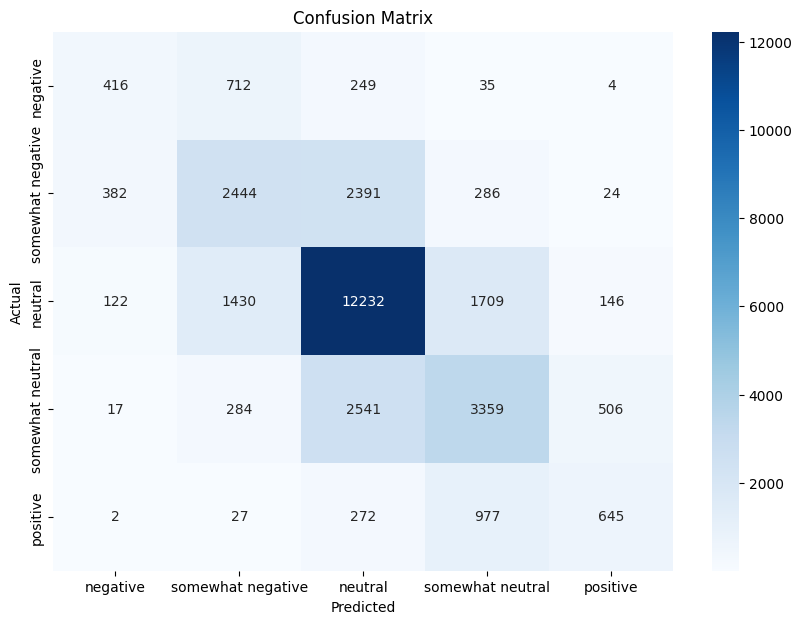

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'somewhat negative', 'neutral', 'somewhat neutral', 'positive'], yticklabels=['negative', 'somewhat negative', 'neutral', 'somewhat neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

According with the results we can see a low model, according with that we can conclude the followiung points:

**Class Imbalance Impact:**

The support column indicates that there is a class imbalance in the dataset. **Class 2** has a significantly higher number of samples (15,639) compared to other classes, especially classes 0 (1,416) and 4 (1,923). This imbalance likely affects the performance of the model, as it may be biased towards predicting the more frequent classes.

**Performance Across Classes:**

Class 2 (most frequent class): The model performs best on class 2, with a relatively high precision (0.69), recall (0.78), and F1-score (0.73). This suggests that the model is well-tuned to predict this class correctly, likely due to the higher number of examples it sees during training.
Class 1 and Class 3: The model shows moderate performance for classes 1 and 3 with F1-scores of 0.47 and 0.51, respectively. The precision and recall values are relatively balanced, suggesting that the model can predict these classes with a reasonable balance between false positives and false negatives.
Classes 0 and 4: These classes have lower F1-scores (0.35 and 0.40, respectively), indicating that the model struggles to predict them accurately. The lower recall (0.29 for class 0 and 0.34 for class 4) suggests that the model frequently misses these classes, likely because they are underrepresented in the dataset.


**Potential for Misclassification:**

Given the lower precision and recall for certain classes, especially 0 and 4, there is a potential for misclassification, which could lead to significant errors in a real-world application. It would be beneficial to analyze the confusion matrix to understand which specific classes are being confused with each other.

#6. Applying Text Preprocessing Techniques

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download additional NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Case folding
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Apply stemming and lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing
df['Processed_Phrase'] = df['Phrase'].apply(preprocess_text)

# Create a Bag of Words model with frequency counts instead of binary
vectorizer = CountVectorizer(binary=False)
X_bow_processed = vectorizer.fit_transform(df['Processed_Phrase'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow_processed, y, test_size=0.2, random_state=42)

# Train the model with preprocessed data
#Initialize and train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict the labels on the test set with preprocessed data
y_pred = model.predict(X_test)

# Evaluate the model with preprocessed data
print(classification_report(y_test, y_pred))
print("Accuracy with preprocessing:", accuracy_score(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              precision    recall  f1-score   support

           0       0.49      0.25      0.34      1416
           1       0.51      0.39      0.44      5527
           2       0.67      0.82      0.74     15639
           3       0.52      0.47      0.49      6707
           4       0.49      0.26      0.34      1923

    accuracy                           0.61     31212
   macro avg       0.54      0.44      0.47     31212
weighted avg       0.59      0.61      0.59     31212

Accuracy with preprocessing: 0.6083557606048956


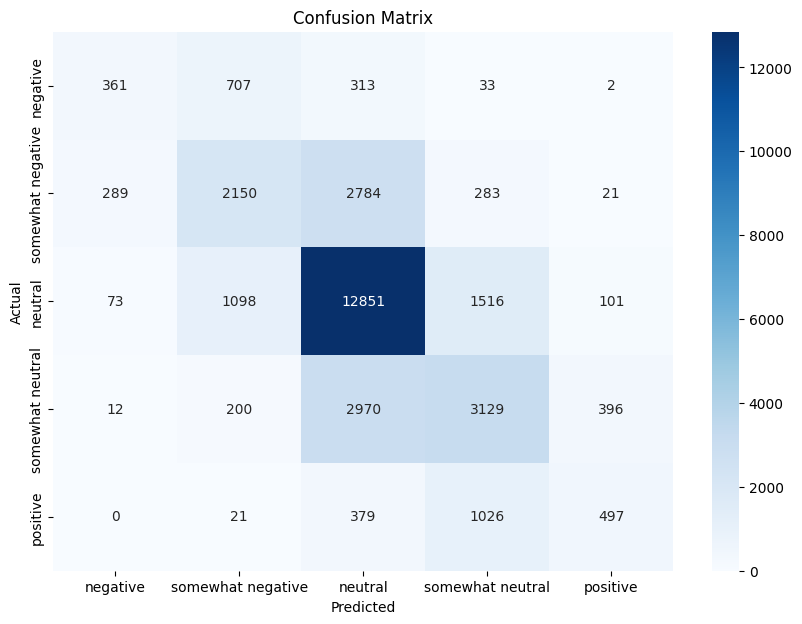

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'somewhat negative', 'neutral', 'somewhat neutral', 'positive'], yticklabels=['negative', 'somewhat negative', 'neutral', 'somewhat neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##7. How does these techniques affect your models?

We can conclude that removing the Stop Words, Stemming and Lemmatization affect the Accuracy of the model:

* Removing common words might lead to a loss of context, especially if these words contribute to the sentiment in a subtle way.
* Stemming and Lemmatization reduce the vocabulary size, they might also lead to information loss, especially in cases where the form of the word carries important sentiment information.

* The preprocessing techniques applied here had a mixed impact, slightly reducing the model's overall performance. For this particular dataset, the raw text's structure might already be better for Naive Bayes without any preprocessing.





